# Baseline Intent Classification on Banking77

In this notebook, we build a **baseline intent classification model** using the [Banking77 dataset](https://huggingface.co/datasets/banking77), which contains 13,000 customer queries across 77 banking-related intents.

The goals of this notebook are:
- Explore the dataset and visualize the distribution of intents.
- Train a simple **TF-IDF + Logistic Regression** model as a baseline.
- Evaluate performance on validation and test sets with metrics and confusion matrices.
- Analyze model confidence and identify the most frequent confusions.
- Save the trained baseline model for later use in the project API.

This provides a **reference point** before moving to more advanced models (e.g. transformer-based embeddings with DistilBERT) and integrating a **RAG pipeline** over banking FAQs.

In [18]:
# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

DATA = Path("../data/processed")

In [19]:
# 2. Load data
train = pd.read_csv(DATA/"train.csv")
val   = pd.read_csv(DATA/"val.csv")
test  = pd.read_csv(DATA/"test.csv")

train.head()


,text,intent
0,What can I do if my card still hasn't arrived ...,card_arrival
1,I have been waiting over a week. Is the card s...,card_arrival
2,"How do I know if I will get my card, or if it ...",card_arrival
3,When did you send me my new card?,card_arrival
4,Do you have info about the card on delivery?,card_arrival


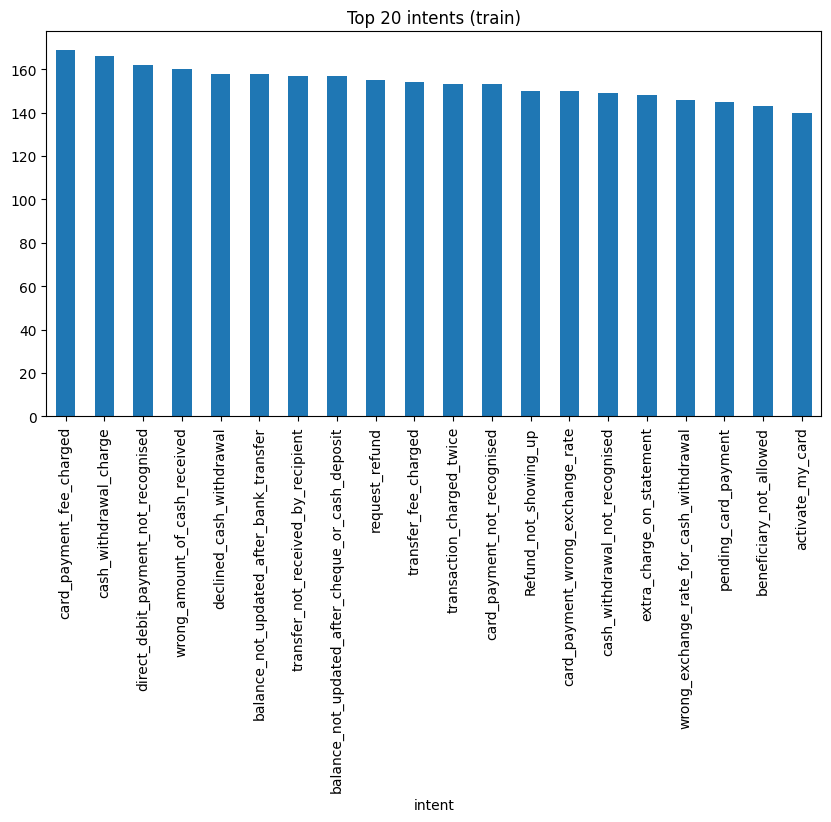

In [20]:
# 3. Explore label distribution
plt.figure(figsize=(10,5))
train["intent"].value_counts().head(20).plot(kind="bar")
plt.title("Top 20 intents (train)")
plt.show()


In [21]:
# 4. Train TF-IDF + Logistic Regression baseline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

pipe.fit(train.text, train.intent)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))])

In [22]:
# 5. Evaluate on validation
val_preds = pipe.predict(val.text)
print(classification_report(val.intent, val_preds, zero_division=0))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       1.00      0.83      0.91        12
                                activate_my_card       1.00      0.79      0.88        19
                                       age_limit       1.00      1.00      1.00        13
                         apple_pay_or_google_pay       1.00      1.00      1.00        11
                                     atm_support       1.00      0.92      0.96        12
                                automatic_top_up       0.92      0.86      0.89        14
         balance_not_updated_after_bank_transfer       0.67      0.77      0.71        13
balance_not_updated_after_cheque_or_cash_deposit       0.85      0.96      0.90        24
                         beneficiary_not_allowed       0.92      0.85      0.88        13
                                 cancel_transfer       0.85      0.89      0.87        19
         

In [23]:
# 6. Evaluate on test
test_preds = pipe.predict(test.text)
print(classification_report(test.intent, test_preds, zero_division=0))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.90      0.95      0.93        40
                                activate_my_card       0.97      0.90      0.94        40
                                       age_limit       1.00      1.00      1.00        40
                         apple_pay_or_google_pay       0.98      1.00      0.99        40
                                     atm_support       0.89      0.80      0.84        40
                                automatic_top_up       1.00      0.90      0.95        40
         balance_not_updated_after_bank_transfer       0.65      0.78      0.70        40
balance_not_updated_after_cheque_or_cash_deposit       0.82      0.90      0.86        40
                         beneficiary_not_allowed       0.85      0.88      0.86        40
                                 cancel_transfer       0.90      0.95      0.93        40
         

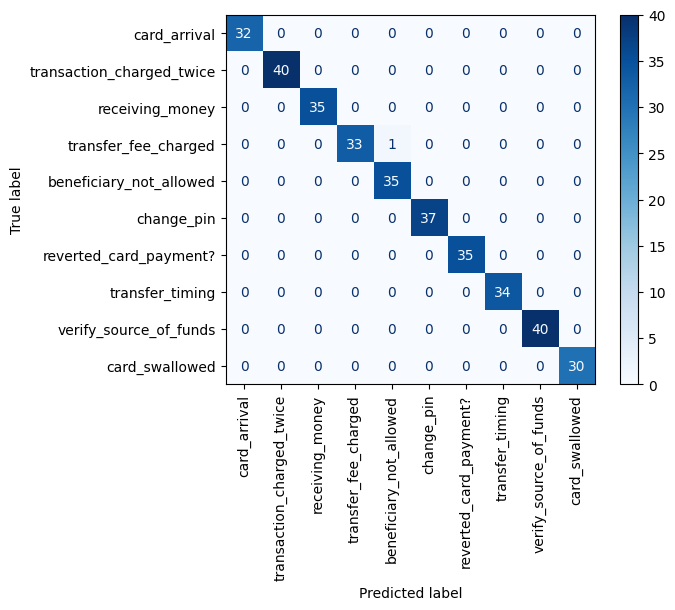

In [24]:
# 7. Confusion matrix for a few frequent intents
ConfusionMatrixDisplay.from_estimator(
    pipe, test.text, test.intent,
    labels=test.intent.value_counts().head(10).index,
    xticks_rotation="vertical", cmap="Blues"
)
plt.show()

In [25]:
# 8. Try custom predictions
examples = [
    "I lost my bank card, what should I do?",
    "How can I get a loan?",
    "I want to change my address",
    "I saw a fraudulent transaction on my account"
]
for q in examples:
    print(q, "->", pipe.predict([q])[0])


I lost my bank card, what should I do? -> lost_or_stolen_card
How can I get a loan? -> order_physical_card
I want to change my address -> edit_personal_details
I saw a fraudulent transaction on my account -> transaction_charged_twice


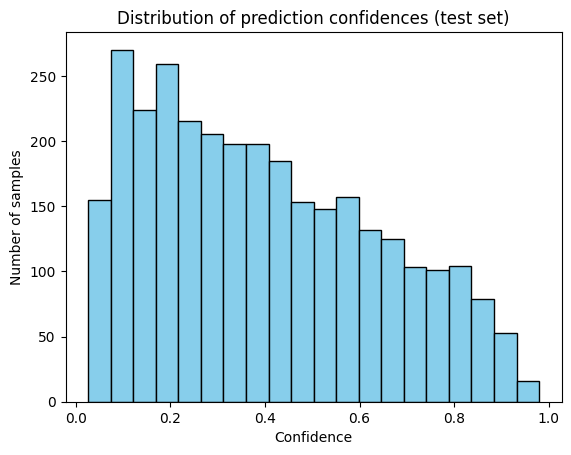

In [27]:
import numpy as np

probas = pipe.predict_proba(test.text)
max_confidences = np.max(probas, axis=1)

plt.hist(max_confidences, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of prediction confidences (test set)")
plt.xlabel("Confidence")
plt.ylabel("Number of samples")
plt.show()

In [28]:
examples = [
    "I lost my bank card, what should I do?",
    "How can I get a loan?",
    "I want to change my address",
    "I saw a fraudulent transaction on my account"
]

for q in examples:
    pred = pipe.predict([q])[0]
    prob = pipe.predict_proba([q])[0].max()
    print(f"Query: {q}\n → Predicted intent: {pred} (confidence {prob:.2f})\n")

Query: I lost my bank card, what should I do?
 → Predicted intent: lost_or_stolen_card (confidence 0.21)

Query: How can I get a loan?
 → Predicted intent: order_physical_card (confidence 0.07)

Query: I want to change my address
 → Predicted intent: edit_personal_details (confidence 0.83)

Query: I saw a fraudulent transaction on my account
 → Predicted intent: transaction_charged_twice (confidence 0.09)



In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(test.intent, test_preds, labels=pipe.classes_)
# find top 10 confused pairs
confusions = []
for i, true_label in enumerate(pipe.classes_):
    for j, pred_label in enumerate(pipe.classes_):
        if i != j and cm[i,j] > 0:
            confusions.append((cm[i,j], true_label, pred_label))
            
for c in sorted(confusions, reverse=True)[:10]:
    print(f"{c[0]} times: true={c[1]} → predicted={c[2]}")


11 times: true=virtual_card_not_working → predicted=get_disposable_virtual_card
11 times: true=card_acceptance → predicted=card_not_working
10 times: true=virtual_card_not_working → predicted=getting_virtual_card
7 times: true=unable_to_verify_identity → predicted=verify_my_identity
6 times: true=why_verify_identity → predicted=verify_my_identity
5 times: true=verify_my_identity → predicted=why_verify_identity
5 times: true=top_up_reverted → predicted=top_up_failed
5 times: true=top_up_by_cash_or_cheque → predicted=balance_not_updated_after_cheque_or_cash_deposit
5 times: true=pending_transfer → predicted=transfer_timing
5 times: true=get_disposable_virtual_card → predicted=disposable_card_limits


## Error Analysis: Top Confusions

The baseline model often confuses intents that are semantically very close:
- **Virtual card issues**: "virtual_card_not_working" is misclassified as "getting_virtual_card" or "get_disposable_virtual_card".
- **Card usage**: "card_acceptance" misclassified as "card_not_working".
- **Identity verification**: "why_verify_identity" ↔ "verify_my_identity".
- **Top-up issues**: "top_up_reverted" ↔ "top_up_failed".

This highlights a limitation of bag-of-words features (TF-IDF). The model can’t capture semantic meaning beyond word overlap.

### Next step
To better separate such cases, we need contextual embeddings (e.g., **DistilBERT**) that understand meaning, not just word frequency.

## Baseline Results
- **Model**: TF-IDF (1–2 grams) + Logistic Regression
- **Accuracy/F1**: (paste from classification_report)
- **Observation**: Model performs well on surface-level queries but struggles with semantically close intents.
- **Confidence Analysis**: Many predictions have <0.3 confidence → indicates weak generalization.
- **Next Step**: Explore transformer embeddings (DistilBERT) and add RAG for robustness.

In [30]:
import joblib
from pathlib import Path

MODELS = Path("../models/intent/sklearn"); MODELS.mkdir(parents=True, exist_ok=True)
joblib.dump(pipe, MODELS/"model.joblib")


['../models/intent/sklearn/model.joblib']